# Import all essential libraries required for data preprocessing, modeling, and interpretability in this experiment.

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

# Import and display the dataset to begin preprocessing and model development.

In [12]:
df = pd.read_csv("breast_cancer.csv")
df.head()

,Age,Race,Marital Status,Unnamed: 3,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,43,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N3,IIIC,Moderately differentiated; Grade II,Regional,40,Positive,Positive,19,11,1,Alive
1,47,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,45,Positive,Positive,25,9,2,Alive
2,67,White,Married (including common law),NaN,T2,N1,IIB,Poorly differentiated; Grade III,Regional,25,Positive,Positive,4,1,2,Dead
3,46,White,Divorced,NaN,T1,N1,IIA,Moderately differentiated; Grade II,Regional,19,Positive,Positive,26,1,2,Dead
4,63,White,Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,35,Positive,Positive,21,5,3,Dead


In [13]:
df.describe()

,Age,Unnamed: 3,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months
count,4024.000000,0.0,4024.000000,4024.000000,4024.000000,4024.000000
mean,53.972167,NaN,30.473658,14.357107,4.158052,71.297962
std,8.963134,NaN,21.119696,8.099675,5.109331,22.921430
min,30.000000,NaN,1.000000,1.000000,1.000000,1.000000
25%,47.000000,NaN,16.000000,9.000000,1.000000,56.000000
50%,54.000000,NaN,25.000000,14.000000,2.000000,73.000000
75%,61.000000,NaN,38.000000,19.000000,5.000000,90.000000
max,69.000000,NaN,140.000000,61.000000,46.000000,107.000000


# Convert the 'Survival Months' column to numeric format to ensure consistency and handle potential non-numeric values (just in case).

In [14]:
df['Survival Months'] = pd.to_numeric(df['Survival Months'], errors='coerce')

# Drop Survival Months Column

In [15]:
df.dropna(subset=['Survival Months'], inplace=True)

# Create the new target: Survival_5yr Column

In [16]:
df['Survival_5yr'] = np.where(df['Survival Months'] >= 60, 1, 0)

# Drop original status and survival months to avoid leakage

In [17]:
df.drop(['Status', 'Survival Months'], axis=1, inplace=True)

# One-hot encode categorical columns

In [18]:
df_encoded = pd.get_dummies(df, drop_first=True)

# Assume df is your DataFrame and the target variable is in 'Survival_5yr'

In [19]:
X = df_encoded.drop('Survival_5yr', axis=1)
y = df_encoded['Survival_5yr']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train

In [20]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Generate predictions using the trained model on test data and  Evaluate the model's performance

In [21]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6521739130434783

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.13      0.20       258
           1       0.69      0.90      0.78       547

    accuracy                           0.65       805
   macro avg       0.53      0.51      0.49       805
weighted avg       0.59      0.65      0.59       805


Confusion Matrix:
 [[ 34 224]
 [ 56 491]]


# ROC curve (Receiver Operating Characteristic curve) for a Random Forest model for top 10

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_model = RandomForestClassifier(random_state=42)
base_model.fit(X_train, y_train)

feat_importances = pd.Series(base_model.feature_importances_, index=X_train.columns)
top_features = feat_importances.sort_values(ascending=False).head(10).index

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

best_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)
best_model.fit(X_train_top, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


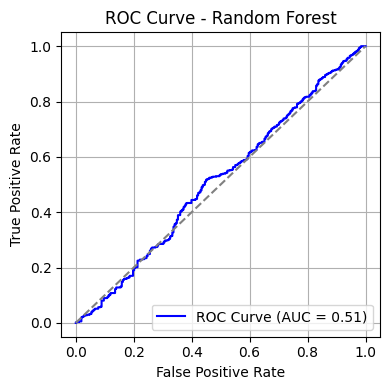

In [23]:
y_probs = best_model.predict_proba(X_test_top)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

In [24]:
importances = model.feature_importances_
feature_names = X.columns 
feat_importances = pd.Series(importances, index=feature_names)

# Select top 5 features and plot

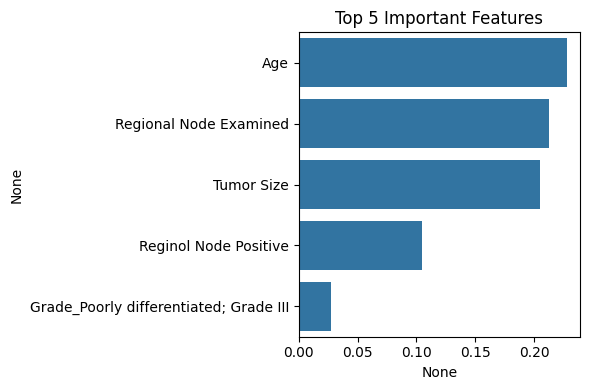

In [25]:
plt.figure(figsize=(6, 4))
sns.barplot(x=feat_importances.sort_values(ascending=False)[:5],
            y=feat_importances.sort_values(ascending=False).index[:5])
plt.title("Top 5 Important Features")

plt.tight_layout()
plt.show()

# Training Model on Top 5 Important Features (Random Forest)

In [26]:
top_features = feat_importances.sort_values(ascending=False).head(5)

X_train_top = X_train[top_features.index]
X_test_top = X_test[top_features.index]

model_top = RandomForestClassifier(random_state=42)
model_top.fit(X_train_top, y_train)

y_pred = model_top.predict(X_test_top)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.17      0.22       258
           1       0.68      0.84      0.75       547

    accuracy                           0.63       805
   macro avg       0.51      0.51      0.49       805
weighted avg       0.57      0.63      0.58       805



# Select top 10 features and plot

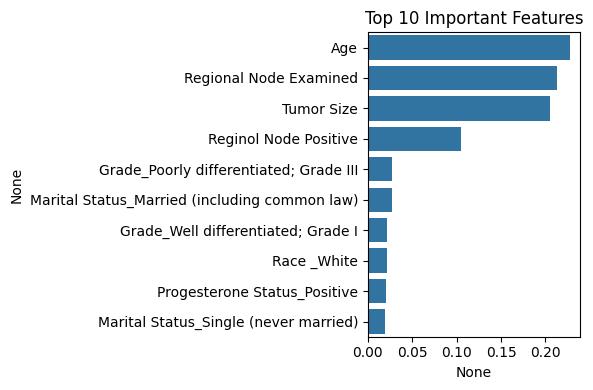

In [27]:
top_features = feat_importances.sort_values(ascending=False).head(10)
# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=feat_importances.sort_values(ascending=False)[:10],
            y=feat_importances.sort_values(ascending=False).index[:10])
plt.title("Top 10 Important Features")

plt.tight_layout()
plt.show()

# Training Model on Top 10 Important Features (Random Forest)

In [28]:
top_features = feat_importances.sort_values(ascending=False).head(10)

X_train_top = X_train[top_features.index]
X_test_top = X_test[top_features.index]

model_top = RandomForestClassifier(random_state=42)
model_top.fit(X_train_top, y_train)

y_pred = model_top.predict(X_test_top)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.40      0.16      0.23       258
           1       0.69      0.88      0.78       547

    accuracy                           0.65       805
   macro avg       0.54      0.52      0.50       805
weighted avg       0.60      0.65      0.60       805



## Hyperparameter tuning on a RandomForestClassifier using grid search with cross-validation to find the best combination of model parameters that gives the highest accuracy.

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_top, y_train)

print("Best Hyperparameters:")
print(grid_search.best_params_)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_top)
print(classification_report(y_test, y_pred))

Best Hyperparameters:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.46      0.05      0.09       258
           1       0.68      0.97      0.80       547

    accuracy                           0.68       805
   macro avg       0.57      0.51      0.45       805
weighted avg       0.61      0.68      0.58       805




 Evaluation for: Top 5 Features
Mean Accuracy:  0.6571 ± 0.0085
Mean F1 Score:  0.7798 ± 0.0053
Mean ROC-AUC:   0.5453 ± 0.0094

 Evaluation for: Top 10 Features
Mean Accuracy:  0.6787 ± 0.0079
Mean F1 Score:  0.7972 ± 0.0058
Mean ROC-AUC:   0.5514 ± 0.0145


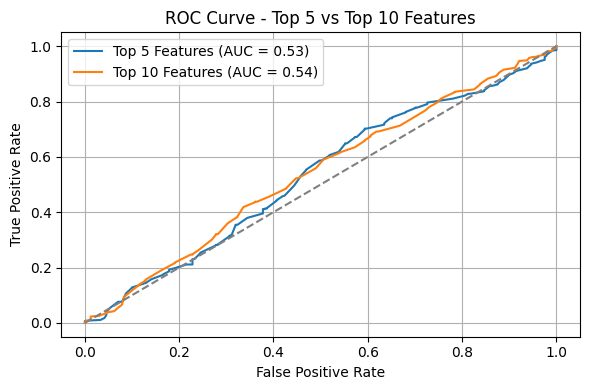

In [30]:
from sklearn.metrics import precision_score

# Fit full model to determine feature importances
full_model = RandomForestClassifier(n_estimators=100, random_state=42)
full_model.fit(X, y)
importances = full_model.feature_importances_

#  Get top 5 and top 10 features
feat_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top5_features = feat_df['Feature'].iloc[:5].tolist()
top10_features = feat_df['Feature'].iloc[:10].tolist()

#  Evaluation function with cross-validation
def evaluate_with_cv(X_subset, y, title):
    print(f"\n Evaluation for: {title}")

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validation scores
    acc_scores = cross_val_score(model, X_subset, y, cv=skf, scoring='accuracy')
    f1_scores = cross_val_score(model, X_subset, y, cv=skf, scoring='f1')
    roc_scores = cross_val_score(model, X_subset, y, cv=skf, scoring='roc_auc')

    print(f"Mean Accuracy:  {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
    print(f"Mean F1 Score:  {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
    print(f"Mean ROC-AUC:   {roc_scores.mean():.4f} ± {roc_scores.std():.4f}")

    # Fit on one train/test split for ROC curve
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42, stratify=y)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{title} (AUC = {roc_auc_score(y_test, y_proba):.2f})")

#  Evaluate and visualize
plt.figure(figsize=(6, 4))
evaluate_with_cv(X[top5_features], y, "Top 5 Features")
evaluate_with_cv(X[top10_features], y, "Top 10 Features")

#  Plot ROC Curve
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Top 5 vs Top 10 Features")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Create an explainer with the trained model, compute SHAP values for the test data, select the positive class values if binary classification, and plot feature importance using bar and detailed summary plots.

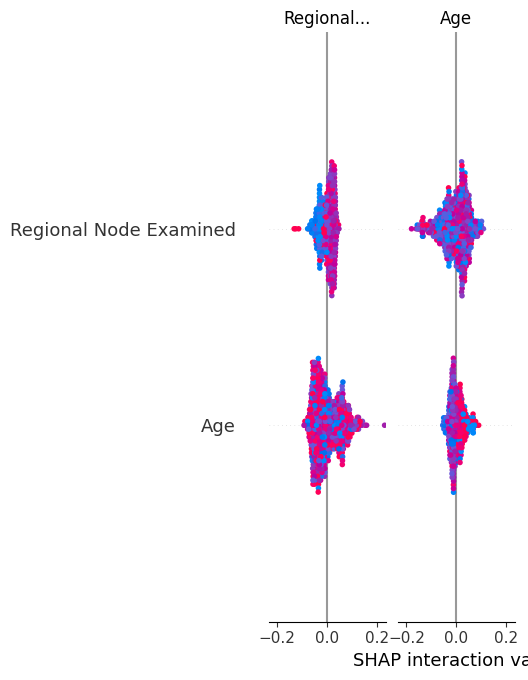

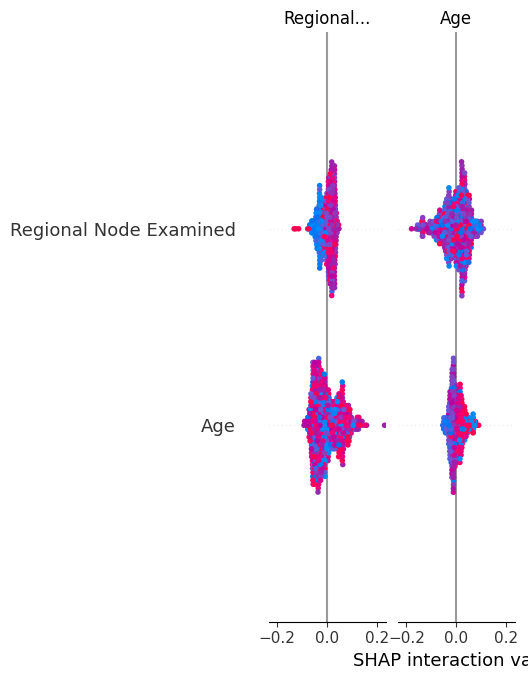

In [31]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_top)

if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]  
else:
    shap_values_to_plot = shap_values

shap.summary_plot(shap_values_to_plot, X_test_top, plot_type="bar")

shap.summary_plot(shap_values_to_plot, X_test_top)

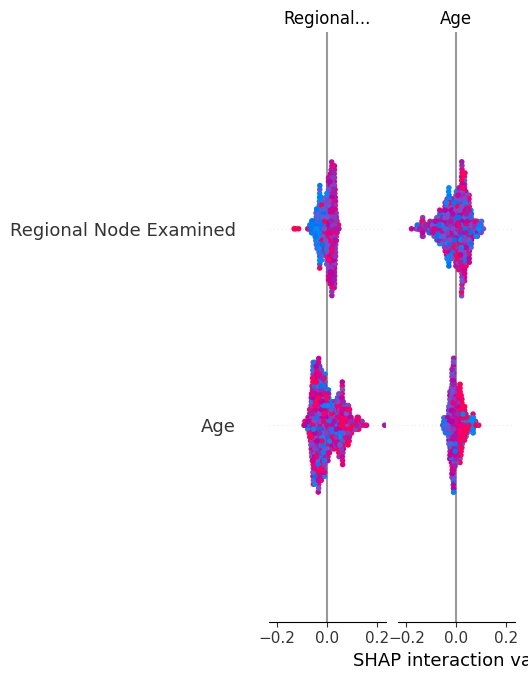

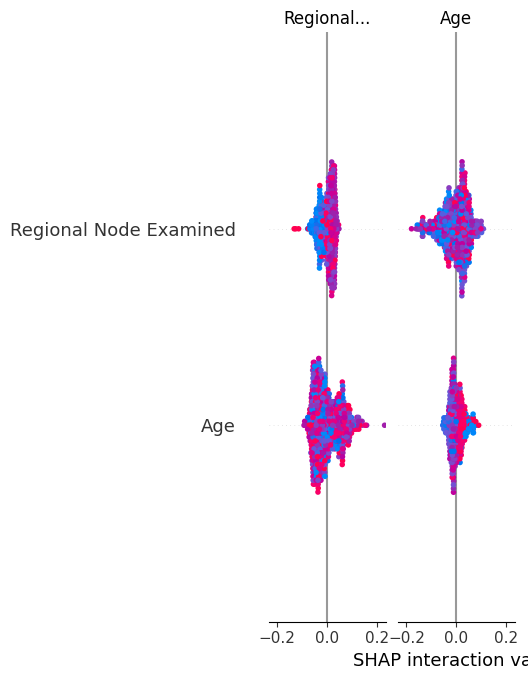

In [32]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_top)

if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]  
else:
    shap_values_to_plot = shap_values

shap.summary_plot(shap_values_to_plot, X_test_top, plot_type="bar")

shap.summary_plot(shap_values_to_plot, X_test_top)


## Load data and split it. Train RandomForest on all features. Select top 5 and 10 features. Retrain models on these subsets. Compute SHAP values and pick a sample to explain.

In [33]:
df = pd.read_csv("breast_cancer.csv")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)

top5_features = feat_importances.nlargest(5).index
top10_features = feat_importances.nlargest(10).index

X_train_top5 = X_train[top5_features]
X_test_top5 = X_test[top5_features]
X_train_top10 = X_train[top10_features]
X_test_top10 = X_test[top10_features]

model_top5 = RandomForestClassifier(random_state=42)
model_top5.fit(X_train_top5, y_train)

model_top10 = RandomForestClassifier(random_state=42)
model_top10.fit(X_train_top10, y_train)

explainer_top5 = shap.TreeExplainer(model_top5)
explainer_top10 = shap.TreeExplainer(model_top10)

shap_values_top5 = explainer_top5.shap_values(X_test_top5)[1]
shap_values_top10 = explainer_top10.shap_values(X_test_top10)[1]

sample_index = 0  

## Print and display waterfall plots for the top 5 and top 10 features using SHAP values for a chosen sample

 SHAP Waterfall Plot: Top 5 Features


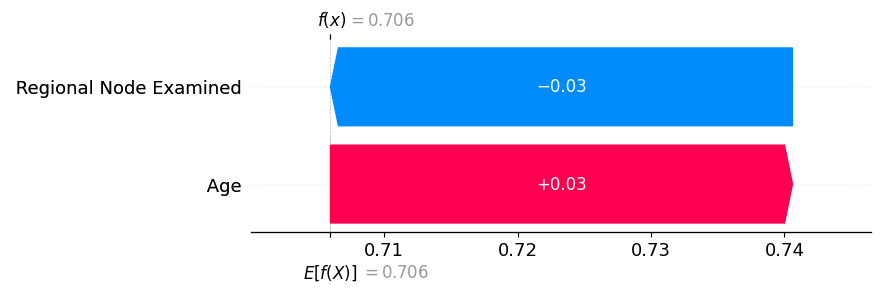

 SHAP Waterfall Plot: Top 10 Features


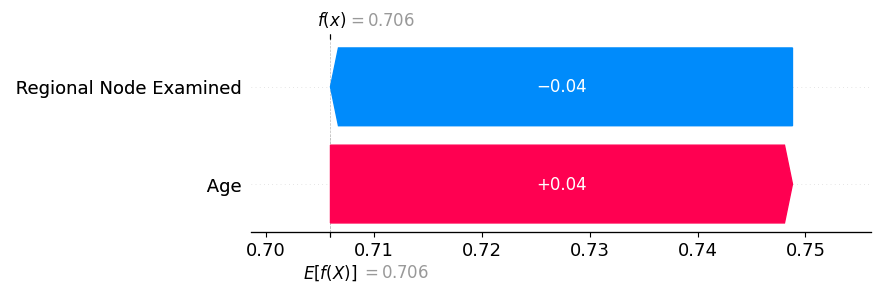

In [34]:
print(" SHAP Waterfall Plot: Top 5 Features")
shap.plots._waterfall.waterfall_legacy(
    explainer_top5.expected_value[1],
    shap_values_top5[sample_index],
    X_test_top5.iloc[sample_index]
)

print(" SHAP Waterfall Plot: Top 10 Features")
shap.plots._waterfall.waterfall_legacy(
    explainer_top10.expected_value[1],
    shap_values_top10[sample_index],
    X_test_top10.iloc[sample_index]
)

## Waterfall for top 5 and top 10 features

SHAP Waterfall – Top 5 Features


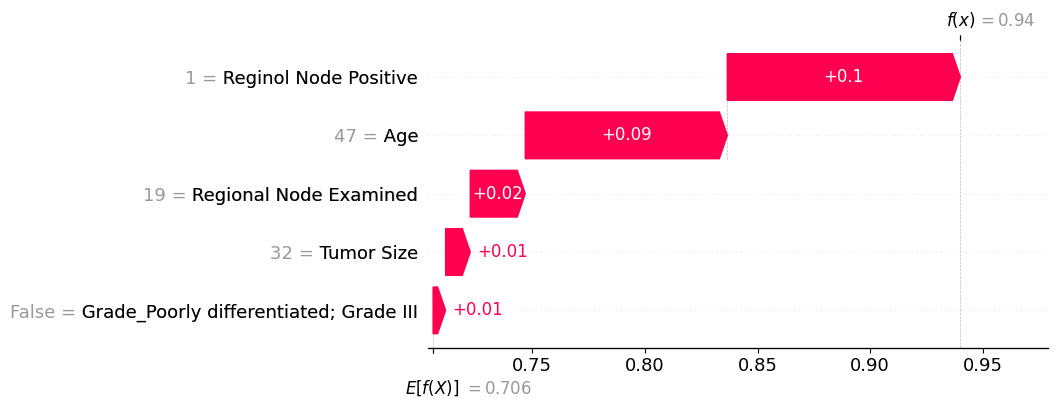


SHAP Waterfall – Top 10 Features


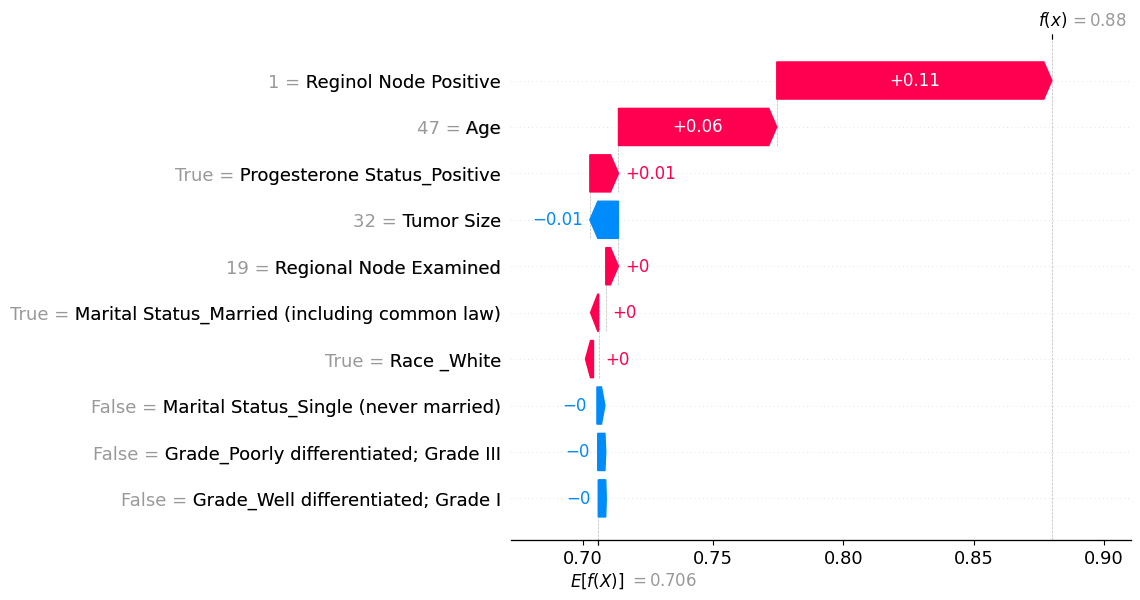

In [39]:
import numpy as np
import shap

def get_shap_2d_and_base(explainer, X, class_index=1):
    """
    Return (shap_values_2d, base_value_scalar) for a single output (class_index).
    Handles SHAP versions that return lists, 3D arrays, or Explanation objects.
    """
    sv = explainer.shap_values(X)

    
    ev = explainer.expected_value
    if isinstance(ev, (list, np.ndarray)):
        ev = ev[class_index]
    ev = float(np.asarray(ev).ravel()[0])

    
    if isinstance(sv, list):
        # Classic: list per class
        sv = sv[class_index]
    else:
        sv = np.asarray(sv)

    # Possible shapes:
    # (n_samples, n_features) -> OK
    # (n_samples, n_features, n_outputs) -> take output axis
    # (n_features, n_outputs) -> single sample already -> take output axis
    if sv.ndim == 3:
        sv = sv[:, :, class_index]
    elif sv.ndim == 2:
        # already (n_samples, n_features)
        pass
    elif sv.ndim == 1:
        # Rare case: single-sample flattened
        sv = sv[None, :]
    else:
        # (n_features, n_outputs) for a single sample
        if sv.shape[-1] > 1:
            sv = sv[:, class_index][None, :]
        else:
            sv = sv[:, 0][None, :]

    return sv, ev

def waterfall_safe(base_value, sv_row, feature_names, data_row=None, max_display=None):
    """Try modern waterfall; fall back to legacy if needed."""
    try:
        shap.plots.waterfall(
            shap.Explanation(
                values=sv_row,
                base_values=base_value,
                feature_names=feature_names,
                data=data_row
            ),
            max_display=max_display,
            show=True
        )
    except Exception:
        shap.plots._waterfall.waterfall_legacy(
            base_value,
            sv_row,
            features=data_row if data_row is not None else None,
            feature_names=feature_names,
            max_display=max_display
        )


explainer_top5  = shap.TreeExplainer(model_top5)
explainer_top10 = shap.TreeExplainer(model_top10)

sv5, base5   = get_shap_2d_and_base(explainer_top5,  X_test_top5,  class_index=1)
sv10, base10 = get_shap_2d_and_base(explainer_top10, X_test_top10, class_index=1)

sample_index = max(0, min(0, len(X_test_top10) - 1))  

print("SHAP Waterfall – Top 5 Features")
sv5_row   = sv5[sample_index]              
feat5     = list(X_test_top5.columns)
data5_row = X_test_top5.iloc[sample_index, :].values
waterfall_safe(base5, sv5_row, feat5, data_row=data5_row, max_display=5)

print("\nSHAP Waterfall – Top 10 Features")
sv10_row   = sv10[sample_index]
feat10     = list(X_test_top10.columns)
data10_row = X_test_top10.iloc[sample_index, :].values
waterfall_safe(base10, sv10_row, feat10, data_row=data10_row, max_display=10)


## Top 5 and top 10 feature importance


Top 5 Features:
                                    Feature  Importance
0                                      Age    0.227506
3                   Regional Node Examined    0.212882
2                               Tumor Size    0.204808
4                    Reginol Node Positive    0.104618
20  Grade_Poorly differentiated; Grade III    0.027547

Top 10 Features:
                                           Feature  Importance
0                                             Age    0.227506
3                          Regional Node Examined    0.212882
2                                      Tumor Size    0.204808
4                           Reginol Node Positive    0.104618
20         Grade_Poorly differentiated; Grade III    0.027547
7   Marital Status_Married (including common law)    0.027502
22             Grade_Well differentiated; Grade I    0.021763
6                                     Race _White    0.021712
25                   Progesterone Status_Positive    0.020984
9           M

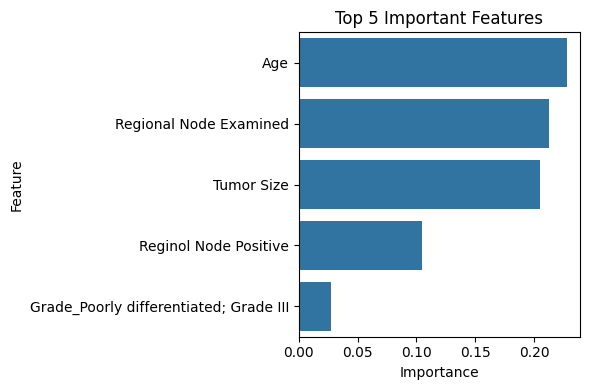

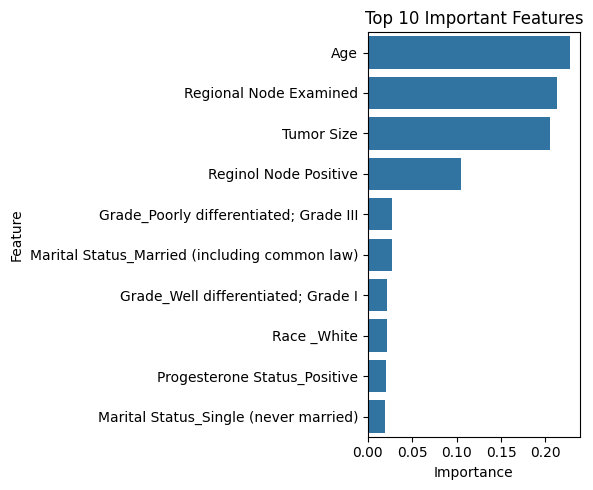

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


feat_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)


print("\nTop 5 Features:\n", feat_df.head(5))
print("\nTop 10 Features:\n", feat_df.head(10))


plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(5))
plt.title("Top 5 Important Features")
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 5))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(10))
plt.title("Top 10 Important Features")
plt.tight_layout()
plt.show()